In [1]:
from google.colab import files
uploaded = files.upload()

Saving articles2.csv to articles2.csv


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import io

meow = pd.read_csv(io.BytesIO(uploaded['articles2.csv']))

meow.loc[(meow["sentiment"] < -1/10) & (meow["sentiment"] >= -1) , "sentiment"] = -1
meow.loc[(meow["sentiment"] < 1/10) & (meow["sentiment"] >= -1/10) , "sentiment"] = 0
meow.loc[(meow["sentiment"] <= 1) & (meow["sentiment"] >= 1/10) , "sentiment"] = 1

print(meow['sentiment'].unique())
print(meow['sentiment'].isin([-1]).sum())
print(meow['sentiment'].isin([0]).sum())
print(meow['sentiment'].isin([1]).sum())

positive_df = meow[meow['sentiment'] == 1]
train_positive = positive_df[:3000]
test_positive = positive_df[3000:3750]

neutral_df = meow[meow['sentiment'] == 0]
train_neutral = neutral_df[:3000]
test_neutral = neutral_df[3000:3750]

neg_df = meow[meow['sentiment'] == -1]
train_neg = neg_df[:3000]
test_neg = neg_df[3000:3750]

traindf = train_positive.append([train_neutral,train_neg])
testdf = test_positive.append([test_neutral,test_neg])

df = traindf.append(testdf, sort=False)

#print(meow['sentiment'].head(25))
y = df[["sentiment","location","date","Confirmed"]]
X = df[["tweet"]]

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidfX = vectorizer.fit_transform(X["tweet"])
#print(vectorizer.get_feature_names())
print(tfidfX.shape)

X_train, X_test, y_train, y_test = train_test_split(tfidfX, y, test_size=0.2, random_state=0)

y_train_sent = y_train[["sentiment"]]
y_test_sent = y_test[["sentiment"]]

#modify these C and penalty values to see what accuracy you can get!
C=[1]
penalty=['l1']
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

for i in C:
    for j in penalty:
        clf = LogisticRegression(C = i, penalty=j, solver = 'saga', max_iter = 200).fit(X_train, y_train_sent)
        test_score = clf.score(X_test, y_test_sent)
        print(test_score)
        print(i, j)

test_predictions = clf.predict(X_test)
print(confusion_matrix(y_test_sent,test_predictions))  
print(classification_report(y_test_sent,test_predictions))  
print(accuracy_score(y_test_sent, test_predictions))

#import pickle
#pickle.dump(clf,open("models.pckle",'wb'))
#y_train['predicted_sentiment'] = X_train.apply(lambda x: clf.predict(x['tweet']))


[ 1.  0. -1.]
4691
22734
23143
(11250, 31062)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4097777777777778
1 l1
[[352 170 227]
 [207 297 264]
 [195 265 273]]
              precision    recall  f1-score   support

        -1.0       0.47      0.47      0.47       749
         0.0       0.41      0.39      0.40       768
         1.0       0.36      0.37      0.36       733

    accuracy                           0.41      2250
   macro avg       0.41      0.41      0.41      2250
weighted avg       0.41      0.41      0.41      2250

0.4097777777777778


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


datetime64[ns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


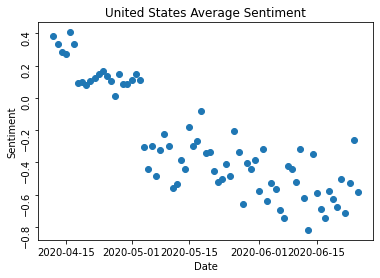

In [7]:

import matplotlib.pyplot as plt
import datetime
dates = y_train['date'].unique()
converted_dates = list(map(datetime.datetime.strptime, dates, len(dates)*['%Y-%m-%d']))
#uncomment and modify state name to whatever you want it to be
#state = ‘Connecticut’

#uncomment this line if you want to plot a specific state's average sentiment
#stateX = X_train.toarray()[(y_train[‘location’]==state)] #& (y_train[‘date’]< ‘2020-04-19’)]

#comment this line out if you want to plot a specific state's average sentiment
stateX = X_train.toarray()

#uncomment this line if you want to plot a specific state's average sentiment
#_df = y_train[(y_train[‘location’]==state)] #& (y_train[‘date’]< ‘2020-04-19’)]

#comment this line out if you want to plot a specific state's average sentiment
y_df = y_train

y_df['date'] = pd.to_datetime(y_df['date'])

print(y_df['date'].dtype)
y_df['predicted_sent'] = clf.predict(stateX)
y_df = y_df.groupby('date', as_index=False).mean()

plt.title('United States Average Sentiment')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.scatter(y_df['date'],list(y_df['predicted_sent']))
plt.yticks(rotation=90)
plt.show()